<a href="https://colab.research.google.com/github/03axdov/Notebooks/blob/main/AudioRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U --pre tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 5.9 MB 42.6 MB/s 
     |████████████████████████████████| 438 kB 47.8 MB/s 
     |████████████████████████████████| 1.7 MB 14.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir=".",
      cache_subdir="data"
  )

182082353/182082353 [==============================] - 1s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != "README.md"]
print(f"Commands: {commands}")

Commands: ['go' 'up' 'stop' 'no' 'left' 'down' 'yes' 'right']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=seed,
    output_sequence_length=16000,
    subset="both"
)

label_names = np.array(train_ds.class_names)
print()
print(f"Labels: {label_names}")

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

Labels: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
for audio_batch, labels_batch in train_ds.take(1):
  print(audio_batch[0].shape)

(16000, 1)


In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

In [9]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for audio_batch, label_batch in train_ds.take(1):
  print(audio_batch.shape)
  print(label_batch.shape)

(64, 16000)
(64,)


In [12]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

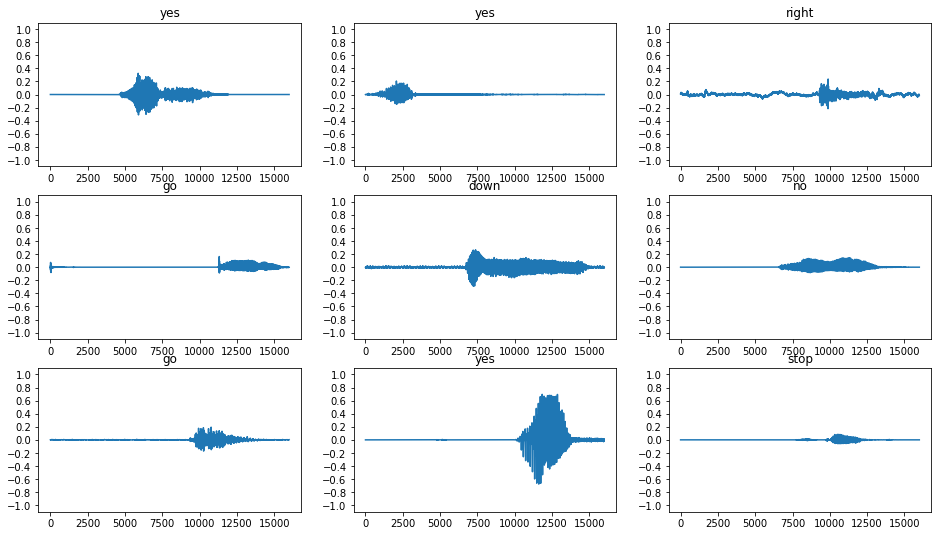

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16,9))

for i in range(n):
  if i >= n:
    break

  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio_batch[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[label_batch[i]]
  ax.set_title(label)
  ax.set_ylim(-1.1, 1.1)

plt.show()

In [17]:
def get_spectogram(waveform):
  spectogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128
  )
  spectogram = tf.abs(spectogram)
  spectogram = spectogram[..., tf.newaxis]
  return spectogram

In [21]:
for i in range(3):
  label = label_names[label_batch[i]]
  waveform = audio_batch[i]
  spectogram = get_spectogram(waveform)
  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [22]:
def plot_spectogram(spectogram, ax):
  if len(spectogram.shape) > 2:
    assert len(spectogram.shape) == 3
    spectogram = np.squeeze(spectogram, axis=-1)

  log_spec = np.log(spectogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

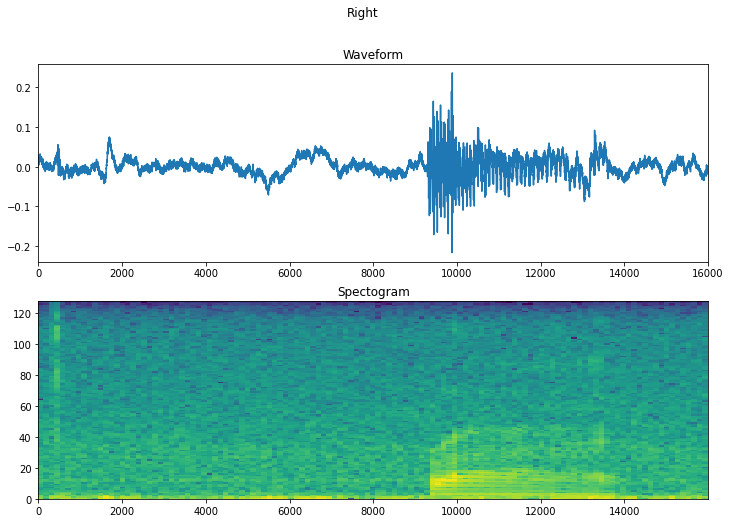

In [23]:
fig, axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title("Waveform")
axes[0].set_xlim([0, 16000])

plot_spectogram(spectogram.numpy(), axes[1])
axes[1].set_title("Spectogram")
plt.suptitle(label.title())
plt.show()

In [24]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE
  )

In [25]:
train_spectogram_ds = make_spec_ds(train_ds)
val_spectogram_ds = make_spec_ds(val_ds)
test_spectogram_ds = make_spec_ds(test_ds)

In [26]:
for spectograms, labels in train_spectogram_ds.take(1):
  break

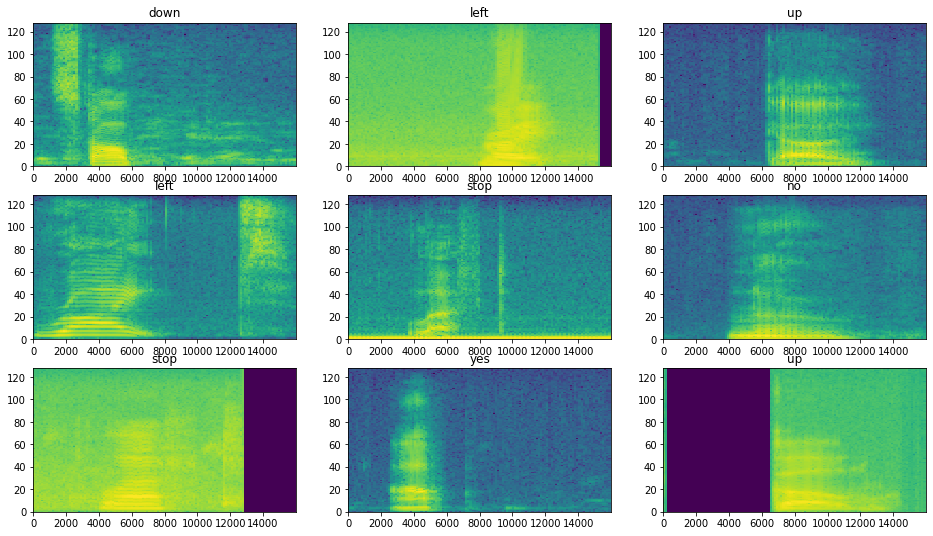

In [27]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectogram(spectograms[i].numpy(), ax)
  ax.set_title(commands[labels[i].numpy()])

plt.show()

In [28]:
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_spectogram_ds = val_spectogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = spectograms.shape[1:]
print(f"Input shape: {input_shape}")
num_labels = len(commands)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_spectogram_ds.map(map_func = lambda spec, label: spec))

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Resizing(32,32),
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [32]:
EPOCHS = 10
history = model.fit(
    train_spectogram_ds,
    validation_data=val_spectogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=1)
)

Epoch 1/10
100/100 [==============================] - 24s 227ms/step - loss: 1.7646 - accuracy: 0.3738 - val_loss: 1.4109 - val_accuracy: 0.5143
Epoch 2/10
100/100 [==============================] - 20s 205ms/step - loss: 1.2278 - accuracy: 0.5778 - val_loss: 0.9901 - val_accuracy: 0.6536
Epoch 3/10
100/100 [==============================] - 20s 205ms/step - loss: 0.9222 - accuracy: 0.6744 - val_loss: 0.7997 - val_accuracy: 0.7435
Epoch 4/10
100/100 [==============================] - 27s 273ms/step - loss: 0.7268 - accuracy: 0.7467 - val_loss: 0.6729 - val_accuracy: 0.7604
Epoch 5/10
100/100 [==============================] - 32s 325ms/step - loss: 0.6219 - accuracy: 0.7817 - val_loss: 0.6150 - val_accuracy: 0.7865
Epoch 6/10
100/100 [==============================] - 34s 338ms/step - loss: 0.5331 - accuracy: 0.8116 - val_loss: 0.5366 - val_accuracy: 0.8255
Epoch 7/10
100/100 [==============================] - 32s 317ms/step - loss: 0.4713 - accuracy: 0.8373 - val_loss: 0.5346 - val_ac

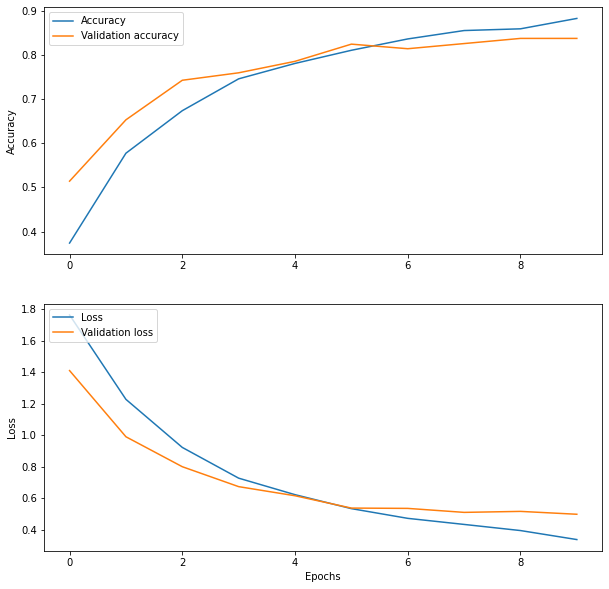

In [33]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(acc, label="Accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc="upper left")

plt.show()

In [34]:
loss, acc = model.evaluate(test_spectogram_ds)
print(f"Accuracy: {acc}")
print(f"Loss: {loss}")

13/13 [==============================] - 2s 166ms/step - loss: 0.5069 - accuracy: 0.8413
Accuracy: 0.8413461446762085
Loss: 0.5068978667259216


In [35]:
y_pred = model.predict(test_spectogram_ds)

13/13 [==============================] - 2s 163ms/step


In [36]:
y_pred = tf.argmax(y_pred, axis=1)

In [37]:
y_true = tf.concat(list(test_spectogram_ds.map(lambda s, label: label)), axis=0)

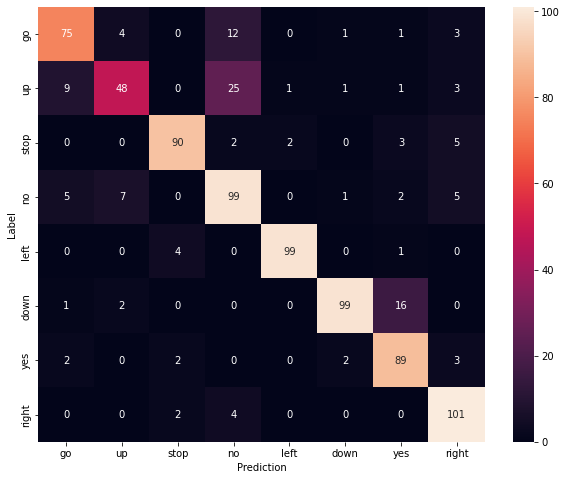

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt="g")
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()